In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import scipy.optimize as optim

# Задача 1

In [2]:
np.random.seed(0)

In [3]:
N = 50000

sigma = 1
n = 50
A = np.eye(n)

m1 = 1000
m2 = 1000

sigma_s = 0.2

In [4]:
def L(w, X, y, A):
    one = np.ones(shape = X.shape[0])
    return np.reshape(np.reshape((1-y), [1,-1])@X@np.reshape(w, [-1,1]) + \
           np.reshape(one, [1,-1])@np.log(1+np.exp(-X@np.reshape(w, [-1,1])))+\
           0.5*np.reshape(w, [1,-1])@np.linalg.inv(A)@np.reshape(w, [-1,1]), -1)/X.shape[0]

def Count_H(A, X, w, m1):
    H = np.linalg.inv(A)
    
    for i in range(m1):
        H += (np.reshape(X[i], [-1,1])@np.reshape(X[i], [1,-1]))*(np.exp(-np.sum(X[i]*w))/(1.0 + np.exp(-np.sum(X[i]*w)))) -\
             (np.reshape(X[i], [-1,1])@np.reshape(X[i], [1,-1]))*(np.exp(-2*np.sum(X[i]*w))/((1.0 + np.exp(-np.sum(X[i]*w)))**2))
             

    return np.linalg.inv(H)

def Acc(p, y):
    y_new = np.round(p)
    return np.sum(y_new==y)/np.size(y)

def Conf(p, y):
    return (np.sum(np.abs(p - 0.5)))/np.size(y)

def Like(p, y):
    return np.exp(np.sum(y*np.log(p)) + np.sum((1-y)*np.log(1-p)))

In [5]:
w = np.random.multivariate_normal(np.zeros(n), A)

X_test = np.random.multivariate_normal(np.zeros(n), sigma**2 * np.eye(n), size = m2)
p_test = np.reshape(1.0/(1.0 + np.exp(-X_test@np.reshape(w, [-1,1]))), -1)

y_test = []
for _p in p_test:
    y_test.append(np.random.choice([1,0], p=[_p, 1-_p]))
y_test = np.array(y_test)

In [6]:
List_of_m1 = np.linspace(10, 5000, num = 100, dtype=np.int64)

List_of_acc_map_test = []
List_of_conf_map_test = []
List_of_like_map_test = []

List_of_acc_bayes_test = []
List_of_conf_bayes_test = []
List_of_like_bayes_test = []

List_of_acc_map_train = []
List_of_conf_map_train = []
List_of_like_map_train = []

List_of_acc_bayes_train = []
List_of_conf_bayes_train = []
List_of_like_bayes_train = []

for m1 in tqdm(List_of_m1):
    X_train = np.random.multivariate_normal(np.zeros(n), sigma**2 * np.eye(n), size = m1)
    p_train = np.reshape(1.0/(1.0 + np.exp(-X_train@np.reshape(w, [-1,1]))), -1)
    
    y_train = []
    for _p in p_train:
        y_train.append(np.random.choice([1,0], p=[_p, 1-_p]))
    y_train = np.array(y_train)
    
    
    
    w_map = optim.minimize(lambda x: L(x, X_train, y_train, A), w, method='BFGS')['x']

    pr_map_y_train = np.reshape(1.0/(1.0 + np.exp(-X_train@np.reshape(w_map, [-1,1]))), -1)
    pr_map_y_test = np.reshape(1.0/(1.0 + np.exp(-X_test@np.reshape(w_map, [-1,1]))), -1)

    
    H = Count_H(A, X_train, w_map, m1)
    
    W_sampling = np.random.multivariate_normal(mean = w_map, cov = H, size = N)

    P = 1.0/(1.0+np.exp(-X_train@W_sampling.T))
    pr_bayes_y_train = np.mean(P, axis=1)

    P = 1.0/(1.0+np.exp(-X_test@W_sampling.T))
    pr_bayes_y_test = np.mean(P, axis=1)

    List_of_acc_map_test.append(Acc(pr_map_y_test, y_test))
    List_of_conf_map_test.append(Conf(pr_map_y_test, y_test))
    List_of_like_map_test.append(Like(pr_map_y_test, y_test))
    
    List_of_acc_bayes_test.append(Acc(pr_bayes_y_test, y_test))
    List_of_conf_bayes_test.append(Conf(pr_bayes_y_test, y_test))
    List_of_like_bayes_test.append(Like(pr_bayes_y_test, y_test))

    List_of_acc_map_train.append(Acc(pr_map_y_train, y_train))
    List_of_conf_map_train.append(Conf(pr_map_y_train, y_train))
    List_of_like_map_train.append(Like(pr_map_y_train, y_train))
    
    List_of_acc_bayes_train.append(Acc(pr_bayes_y_train, y_train))
    List_of_conf_bayes_train.append(Conf(pr_bayes_y_train, y_train))
    List_of_like_bayes_train.append(Like(pr_bayes_y_train, y_train))


100%|██████████| 100/100 [09:01<00:00,  8.91s/it]


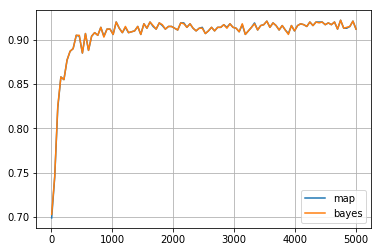

In [7]:
plt.plot(List_of_m1, List_of_acc_map_test, label = 'map')
plt.plot(List_of_m1, List_of_acc_bayes_test, label = 'bayes')

plt.legend(loc = 'best')
plt.grid()
plt.show()

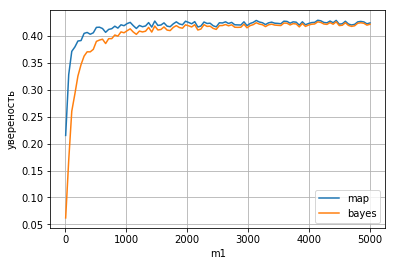

In [8]:
plt.plot(List_of_m1, List_of_conf_map_test, label = 'map')
plt.plot(List_of_m1, List_of_conf_bayes_test, label = 'bayes')

plt.xlabel('m1')
plt.ylabel('увереность')

plt.legend(loc = 'best')
plt.grid()
plt.savefig('Task1_1.pdf')
plt.show()

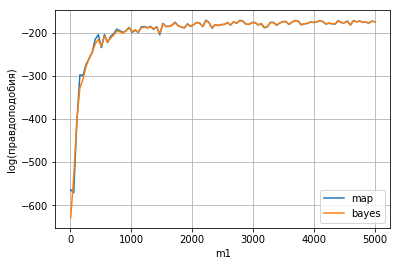

In [9]:
plt.plot(List_of_m1, np.log(List_of_like_map_test), label = 'map')
plt.plot(List_of_m1, np.log(List_of_like_bayes_test), label = 'bayes')

plt.xlabel('m1')
plt.ylabel('log(правдоподобия)')

plt.legend(loc = 'best')
plt.grid()
plt.savefig('Task1_2.pdf')
plt.show()

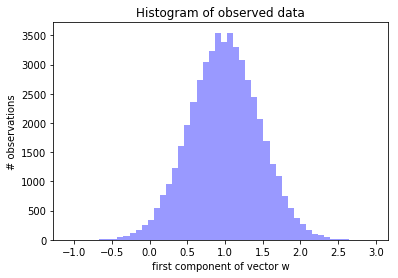

In [15]:
m1 = 100
X_train = np.random.multivariate_normal(np.zeros(n), sigma**2 * np.eye(n), size = m1)
p_train = np.reshape(1.0/(1.0 + np.exp(-X_train@np.reshape(w, [-1,1]))), -1)
                 
y_train = []
for _p in p_train:
    y_train.append(np.random.choice([1,0], p=[_p, 1-_p]))
y_train = np.array(y_train)

w_map = optim.minimize(lambda x: L(x, X_train, y_train, A), w, method='BFGS')['x']

H = Count_H(A, X_train, w_map, m1)

W_sampling = np.random.multivariate_normal(mean = w_map, cov = H, size = N)

ax = plt.subplot() 
sns.distplot(W_sampling[:,0], kde=False, ax = ax, color = 'b')
_ = ax.set(title='Histogram of observed data', xlabel='first component of vector w', ylabel='# observations');

plt.savefig('Task1_3.pdf')
plt.show()

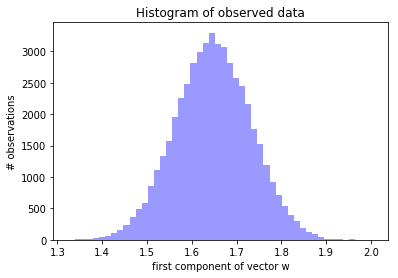

In [14]:
m1 = 5000
X_train = np.random.multivariate_normal(np.zeros(n), sigma**2 * np.eye(n), size = m1)
p_train = np.reshape(1.0/(1.0 + np.exp(-X_train@np.reshape(w, [-1,1]))), -1)
                 
y_train = []
for _p in p_train:
    y_train.append(np.random.choice([1,0], p=[_p, 1-_p]))
y_train = np.array(y_train)
w_map = optim.minimize(lambda x: L(x, X_train, y_train, A), w, method='BFGS')['x']

H = Count_H(A, X_train, w_map, m1)

W_sampling = np.random.multivariate_normal(mean = w_map, cov = H, size = N)

ax = plt.subplot() 
sns.distplot(W_sampling[:,0], kde=False, ax = ax, color = 'b')
_ = ax.set(title='Histogram of observed data', xlabel='first component of vector w', ylabel='# observations');

plt.savefig('Task1_4.pdf')
plt.show()

# Задача 2

# Задача 3

In [2]:
from sympy import solve

In [3]:
from sympy.abc import x

In [4]:
a = 0
b = 3

In [26]:
n = 10000
k = 3000
sigmas = np.linspace(a, b, 101)

List_Of_P_1 = []
for sigma in sigmas:
    List_Of_P_1.append(np.abs(solve(x**3-1.5*(x**2)+x*(0.5-n*(sigma**2))+k*(sigma)**2))[1])

In [27]:
n = 10000
k = 5050
sigmas = np.linspace(a, b, 101)

List_Of_P_2 = []
for sigma in sigmas:
    List_Of_P_2.append(np.abs(solve(x**3-1.5*(x**2)+x*(0.5-n*(sigma**2))+k*(sigma)**2))[1])

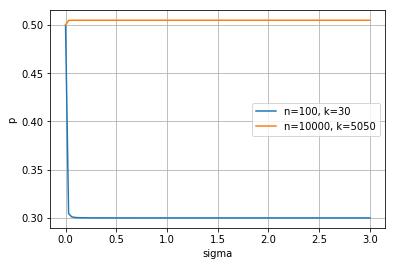

In [28]:
plt.plot(sigmas, List_Of_P_1, label = 'n=100, k=30')
plt.plot(sigmas, List_Of_P_2, label = 'n=10000, k=5050')
plt.xlabel('sigma')
plt.ylabel('p')

plt.legend(loc = 'best')
plt.grid()
plt.savefig('Task3_1_100.pdf')
plt.show()

In [29]:
x**3-1.5*(x**2)+x*(0.5-n*(sigma**2))+k*(sigma)**2

x**3 - 1.5*x**2 - 89999.5*x + 45450.0

In [30]:
from scipy import integrate

In [31]:
def f(x, n, k, sigma):
    return (10**100)*(x**k)*((1-x)**(n-k))*np.exp(-((x-0.5)**2)/(2*(sigma**2)))

def softmax(x):
    return x/np.sum(x)

In [32]:
sigmas = np.linspace(0,3,1000)

In [33]:
List_of_P = []
List_of_P.append(1)
for sigma in sigmas[1:]:
    p_1 = integrate.quad(lambda x: f(x, 10, 3, sigma), 0, 1)[0]
    p_2 = integrate.quad(lambda x: f(x, 200, 101, sigma), 0, 1)[0]
    p_12 = integrate.quad(lambda x: f(x, 10, 3, sigma)*f(x, 200, 101, sigma), 0, 1)[0]
    List_of_P.append(softmax(np.array([p_12, p_1*p_2]))[0])

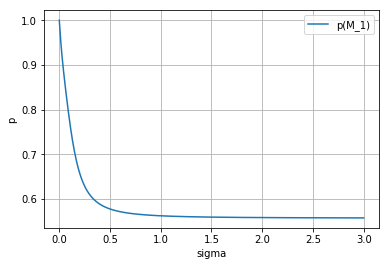

In [34]:
plt.plot(sigmas, List_of_P, label = 'p(M_1)')
plt.xlabel('sigma')
plt.ylabel('p')

plt.legend(loc = 'best')
plt.grid()
plt.savefig('Task3_2.pdf')
plt.show()

In [35]:
sigma = 1

In [36]:
p_1 = integrate.quad(lambda x: f(x, 10, 3, sigma), 0, 1)[0]

In [37]:
p_2 = integrate.quad(lambda x: f(x, 200, 101, sigma), 0, 1)[0]

In [38]:
p_12 = integrate.quad(lambda x: f(x, 10, 3, sigma)*f(x, 200, 101, sigma), 0, 1)[0]

In [39]:
p = softmax(np.array([p_12, p_1*p_2]))

In [40]:
p

array([0.56238867, 0.43761133])

# Задача 5

In [18]:
def D_KL(mu_0, sigma_0, mu_1, sigma_1):
    return 0.5*(np.sum(np.diag(np.linalg.inv(sigma_1)@sigma_0))\
               +np.reshape(mu_1-mu_0, [1,-1])@np.linalg.inv(sigma_1)@np.reshape(mu_1-mu_0, [-1,1])\
               -np.size(mu_0)\
               +np.log(np.linalg.det(sigma_1)/np.linalg.det(sigma_0)))

In [19]:
m_0 = np.array([1,1])
m_1 = np.array([-2,-3])

sigma_0 = np.array([[1,0],[0,1]])
sigma_1 = np.array([[100,0],[0,100]])

In [20]:
D_KL(m_0, sigma_0, m_1, sigma_1)

array([[ 3.74017019]])

In [21]:
D_KL(m_1, sigma_1, m_0, sigma_0)

array([[ 106.89482981]])

In [16]:
from scipy.special import beta

In [23]:
beta(alpha_3,beta_3)

0.0

In [39]:
n_1 = 10
n_2 = 1000

k_1 = 3
k_2 = 505

In [40]:
alpha_1 = k_1+1
beta_1 = n_1-k_1+1

alpha_2 = k_2+1
beta_2 = n_2-k_2+1

alpha_3 = k_1+k_2+1
beta_3 = n_1-k_1+n_2-k_2+1

p = (beta(alpha_3,beta_3))/(beta(alpha_3,beta_3) + beta(alpha_1,beta_1)*beta(alpha_2,beta_2))


In [41]:
print(p, 1-p)

0.553988909493 0.446011090507


In [24]:
from scipy.special import gamma